## Infos ( à supprimer ensuite)

## Variables à ajouter issues des recherches biblio ( à supprimer ensuite)

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 
EXTRA POUR AVOIR 20 : Attribuer un poid aux médailles -> pour potentiellement savoir le nb d'or , argent , bronze

Attention au COVID 19 , influence public , web scrapping sur 30 ans de tous les pays qui ont organisé les jeux 
Attention aux pays pas autorisés à concourir 
Pays en guerre qui envoient moins d'athlètes 
Ukraine 
Palestine 
Iles caiman -> doivent être rattachées à un pays 

JO hiver 
JO été Corrélation 
Apparition des femmes dans les JO ( échantillonnage ) 

Culture du sport : Comment la créer ? 
Budget alloué aux sports (investissement , infrastructures ... ) 
Nb de professionnels 
Nb de licencés 
Nb de sports olympiques disponibles à l'école 

Variable : Pays Communiste ou pas 

Croissance pays économique 

Athlète à partir de 25 ans il n'a plus le niveau : on commence à partir de 2000 , JO Sydney 

Indice dvp des pays à recevoir 

Variable pays organisateur 

Sport qui ont des gens avec un âge bien définie (exemple skate Japonais c'est que des jeunes <= 18 ans)

Dataset coupes mondes de discipline  
    
Variable Note selon l'âge 

Athlète qui sont comptés comme participant à deux pays 

Variable : religion majoritaire pays 

Espérance de vie par pays 
Variable pays dvp ou pas 


Recupérer données JO 2018 et 2021

Variable Poids par Médailles : échelloner les JO de 1 à 10 pour 
Variable Poids par année : 

# Introduction  (Business Understanding) 

## Détermination objectifs métier , analytique du projet 


Objectifs métiers du projet :

Promotion de la performance sportive : Utiliser les données des Jeux olympiques pour améliorer la performance sportive.

Optimisation des ressources : Identifier les sports les plus prometteurs pour optimiser les investissements sportifs.

Prédiction des tendances : Prédire les performances futures des pays et des athlètes en se basant sur les données historiques.

Analyse de la participation : Analyser la participation mondiale aux Jeux olympiques pour identifier les opportunités de croissance.

-------
Objectifs analytiques du projet :

Analyse des performances : Évaluer les performances des pays, des équipes et des athlètes aux Jeux olympiques.

Identification des facteurs de réussite : Identifier les clés du succès dans différents sports et disciplines.

Visualisation des données : Créer des visualisations interactives pour présenter les tendances et les comparaisons de manière compréhensible.

Modélisation prédictive : Développer des modèles prédictifs pour estimer les performances futures.

## Identifier les contraintes , limites et risque du projet

Qualité des données : Les données historiques peuvent être incomplètes ou imprécises.

Variabilité des performances : Les performances sportives sont influencées par de nombreux facteurs difficiles à quantifier.

Interprétation des résultats : Les résultats doivent être interprétés avec prudence en raison de la subjectivité des performances sportives.

Protection des données : Respecter les règles de confidentialité et de protection des données lors de l'analyse des données.

Dépendance aux technologies : Le projet dépend de technologies telles que l'analyse de données, la modélisation statistique, etc.

## Chargement des packages si besoin 

In [1]:
%load_ext ipython_memory_usage 
!pip install ydata_profiling

from ydata_profiling import ProfileReport

import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)

import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
from scipy.stats import chi2_contingency
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from itertools import combinations

from bs4 import BeautifulSoup
import requests
import re
import datetime

imu.start_watching_memory() 

Enabling IPython Memory Usage, use %imu_start to begin, %imu_stop to end


In [1] used 206.4 MiB RAM in 4.51s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 273.4 MiB


# CODE  

## Bases de données disponibles 

In [2]:
df_athlete=pd.read_csv('data/athlete_events.csv')
df_region=pd.read_csv('data/noc_regions.csv')
df_dictionnary=pd.read_csv('data/worldcities.csv', sep=';')

In [2] used 160.1 MiB RAM in 0.48s (system mean cpu 22%, single max cpu 47%), peaked 0.0 MiB above final usage, current RAM usage now 433.5 MiB


#### Pays organisateurs

In [3]:
# TODO: Changer le nom des variables
url='https://www.topendsports.com/events/summer/hosts/list.htm'
response=requests.get(url)
url_2='https://en.wikipedia.org/wiki/List_of_Olympic_Games_host_cities'

response_2=requests.get(url_2)

soup_2=BeautifulSoup(response_2.text,'html.parser')

In [3] used 6.8 MiB RAM in 1.55s (system mean cpu 36%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 440.4 MiB


In [4]:
# TODO: Changer le nom des variables

# Récupération des éléments de la page
L_pays=[]
L_annees=[]
elements=soup_2.findAll('span',class_='datasortkey')

for element in elements:
    pays=element.find('a').text
    L_pays.append(pays)

L_pays=L_pays[42:58]

In [4] used 0.0 MiB RAM in 0.12s (system mean cpu 38%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 440.4 MiB


In [5]:
# Itération des années
L_annees_2=[2000 + i  for i in range(0,34,2)]
L_annees_2.pop(-2)

L_annees_2

[2000,
 2002,
 2004,
 2006,
 2008,
 2010,
 2012,
 2014,
 2016,
 2018,
 2020,
 2022,
 2024,
 2026,
 2028,
 2032]

In [5] used 0.0 MiB RAM in 0.10s (system mean cpu 49%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 440.4 MiB


In [6]:
# On lie les pays et les années

L_pays_annee=[]
for i in range(len(L_pays)):
    L_pays_annee.append((L_pays[i],L_annees_2[i]))

df_hote=pd.DataFrame(L_pays_annee,columns=['Host_country','Year'])

df_hote

,Host_country,Year
0,Australia,2000
1,United States,2002
2,Greece,2004
3,Italy,2006
4,China,2008
5,Canada,2010
6,United Kingdom,2012
7,Russia,2014
8,Brazil,2016
9,South Korea,2018


In [6] used 0.2 MiB RAM in 0.11s (system mean cpu 55%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 440.6 MiB


#### Pays avec un passé communiste

In [7]:
url_soviet='https://en.wikipedia.org/wiki/Post-Soviet_states'
response_soviet=requests.get(url_soviet)
soup_soviet=BeautifulSoup(response_soviet.text,'html.parser')

L_pays_soviet=[]

pays_soviet=soup_soviet.findAll('b')
#print(pays_soviet)
for pays in pays_soviet:
    b=pays.find('a')
    if b is not None:
        L_pays_soviet.append(b.text)
L_pays_soviet=L_pays_soviet[:15]

complete_urss_regime=lambda x : 1 if x in L_pays_soviet else 0

In [7] used 8.6 MiB RAM in 0.59s (system mean cpu 27%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 449.2 MiB


#### Scrap population et GDP

In [8]:
url_pop_gpa='https://www.worldometers.info/gdp/gdp-by-country/'
response_pop_gpa=requests.get(url_pop_gpa)
soup_pop_gpa=BeautifulSoup(response_pop_gpa.text,'html.parser')

L_pays=[]

all_countries=soup_pop_gpa.findAll('td')

for country in all_countries:
    a=country.find('a')
    if a is not None:
        L_pays.append(a.text)
len(L_pays)

177

In [8] used 3.6 MiB RAM in 0.95s (system mean cpu 23%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 452.8 MiB


In [9]:
all_info=soup_pop_gpa.findAll('td',attrs={'style':'font-weight: bold; text-align:right;'})

numbers=[]
for i,info in enumerate(all_info):
    b=re.findall(r'\d+\b', info.text)
    b=''.join(b)
    numbers.append(b)
   
population=[]
gpd_per_habitant=[]
PIB_liste=[]
for i in range(0,len(numbers),6):
    PIB_liste.append(int(numbers[i]))
for i in range(3,len(numbers),6):
    population.append(int(numbers[i]))
for i in range(4,len(numbers),6):
    gpd_per_habitant.append(int(numbers[i]))

print(len(PIB_liste))
PIB_liste

177


[25462700000000,
 17963200000000,
 4231140000000,
 4072190000000,
 3385090000000,
 3070670000000,
 2782910000000,
 2240420000000,
 2139840000000,
 2010430000000,
 1920100000000,
 1675420000000,
 1665250000000,
 1414190000000,
 1397510000000,
 1319100000000,
 1108150000000,
 991115000000,
 905988000000,
 807706000000,
 688177000000,
 632770000000,
 585939000000,
 579267000000,
 578604000000,
 529245000000,
 522033000000,
 507535000000,
 495341000000,
 477386000000,
 476748000000,
 471400000000,
 466789000000,
 460201000000,
 408802000000,
 406306000000,
 405870000000,
 404284000000,
 395404000000,
 388544000000,
 376533000000,
 359839000000,
 343939000000,
 301262000000,
 301025000000,
 290924000000,
 280826000000,
 264182000000,
 251945000000,
 247234000000,
 242632000000,
 237296000000,
 220623000000,
 219066000000,
 191913000000,
 184558000000,
 178789000000,
 160503000000,
 134182000000,
 126783000000,
 115469000000,
 115049000000,
 114667000000,
 113642000000,
 113420000000,
 10671

In [9] used 0.2 MiB RAM in 0.12s (system mean cpu 55%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 453.0 MiB


In [10]:
# On replace les pays qui n'ont pas le même nom
df_pop_gpd=pd.DataFrame({'Country':L_pays,'PIB':PIB_liste,'Population':population,'PIB/habitant':gpd_per_habitant})

df_pop_gpd['Country']=df_pop_gpd['Country'].replace('Trinidad and Tobago','Trinidad')
df_pop_gpd['Country']=df_pop_gpd['Country'].replace('State of Palestine','Palestine, Occupied Territories')
df_pop_gpd['Country']=df_pop_gpd['Country'].replace('Singapore','Singapour')
df_pop_gpd['Country']=df_pop_gpd['Country'].replace('Czech Republic (Czechia)','Czech Republic')
df_pop_gpd['Country']=df_pop_gpd['Country'].replace("Côte d'Ivoire" ,"Cote d'Ivoire")

df_pop_gpd

,Country,PIB,Population,PIB/habitant
0,United States,25462700000000,338289857,75269
1,China,17963200000000,1425887337,12598
2,Japan,4231140000000,123951692,34135
3,Germany,4072190000000,83369843,48845
4,India,3385090000000,1417173173,2389
...,...,...,...,...
172,Sao Tome & Principe,546680342,227380,2404
173,Micronesia,427094119,539013,792
174,Marshall Islands,279667900,41569,6728
175,Kiribati,223352943,131232,1702


In [10] used 0.2 MiB RAM in 0.11s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 453.3 MiB


In [11]:
# Pays qui manquaient sur le site scrappé, données récupérées manuellement
df_pop_gpd=pd.concat([df_pop_gpd,pd.DataFrame([['Taiwan',762670000000,23923276,44460],
                                               ['Cook Islands',220000000,17044,13558],
                                               ['Eritrea',1960000000,3684000,1067],
                                               ['Kosovo',9410000000,1760000,5340],
                                               ['Lebanon',23130000000,5425542,4136],
                                               ['Netherlands Antilles',3810000000,27148,11400],
                                               ['South Sudan',12000000000,11000000,467], 
                                               ['American Samoa',871000000,43914,19673],
                                              ['Aruba',3545000000,106445,333000],
                                              ['Bermuda',7645000000,63532,118774],
                                               ['British Virgin Islands',1751000000,31707,34246],
                                               ['Virgin Islands',4440000000,105413,41974],
                                               ['Cayman Islands',6845000000,69310,99624],
                                               ['Cuba',633400000000,11179471,56495],
                                               ['Guam',6123000000,173825,35904],
                                               ['North Korea',48000000000,26070000,33719],
                                               ['Liechtenstein',7710000000,39039,197504],
                                               ['Monaco',8784000000,39050,240862],
                                               ['Puerto Rico',113400000000,3260314,35208],
                                               ['San Marino',1855000000,33642,53000],
                                               ['Syria',8970000000,22130000,420],
                                               ['Venezuela',92000000000,29254044,2624],
                                               ['Virgin Islands*',4444000000,105413,41976],
                                               ['Afghanistan',14583135237,42239000,363.73],
                                               ['Bhutan',2539551327,782455,3560],
                                               ['Brunei',16760000000,449000,37152],
                                               ['Burma',62260000000,54180000,1149],
                                               ['Cape Verde',2227000000,593000,3754],
                                               ['Djibouti',3515000000,1121000,3136],
                                               ["East Timor (Timor-Leste)",3205000000,1341000,2389],
                                               ['Macedonia',13560000000,2058000,6591],
                                               ['Nauru',151600000,12668,11970],
                                               ['Palau',232000000,18055,12921],
                                               ['Saint Kitts and Nevis',965000000,47000,20262],
                                               ['Saint Vincent and the Grenadines',948000000,9123,9125],
                                               ['Sao Tome and Principe',542000000,227380,2386],
                                               ['Somalia',10042000000,17000000,592],
                                               ['Swaziland',4791000000,1202000,3986],
                                               ['Tonga',469000000,106858,4425],
                                               ['Turkmenistan',56540000000,6431000,8792],
                                               ['Yemen',21160000000,33700000,650]
                                               ],
                                             columns=['Country','PIB','Population','PIB/habitant'])],ignore_index=True)

In [11] used 0.3 MiB RAM in 0.10s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 453.6 MiB


In [12]:
## Dictionnaire pour remplir les valeurs NaN de Pop et PIB sans changer les valeurs de pop et PIB per habitant précédentes
dictio_pop_gpd=dict(zip(df_pop_gpd['Country'],df_pop_gpd['PIB']))

dictio_pop_gpd

{'United States': 25462700000000,
 'China': 17963200000000,
 'Japan': 4231140000000,
 'Germany': 4072190000000,
 'India': 3385090000000,
 'United Kingdom': 3070670000000,
 'France': 2782910000000,
 'Russia': 2240420000000,
 'Canada': 2139840000000,
 'Italy': 2010430000000,
 'Brazil': 1920100000000,
 'Australia': 1675420000000,
 'South Korea': 1665250000000,
 'Mexico': 1414190000000,
 'Spain': 1397510000000,
 'Indonesia': 1319100000000,
 'Saudi Arabia': 1108150000000,
 'Netherlands': 991115000000,
 'Turkey': 905988000000,
 'Switzerland': 807706000000,
 'Poland': 688177000000,
 'Argentina': 632770000000,
 'Sweden': 585939000000,
 'Norway': 579267000000,
 'Belgium': 578604000000,
 'Ireland': 529245000000,
 'Israel': 522033000000,
 'United Arab Emirates': 507535000000,
 'Thailand': 495341000000,
 'Nigeria': 477386000000,
 'Egypt': 476748000000,
 'Austria': 471400000000,
 'Singapour': 466789000000,
 'Bangladesh': 460201000000,
 'Vietnam': 408802000000,
 'Malaysia': 406306000000,
 'South Afr

In [12] used 0.0 MiB RAM in 0.11s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 453.6 MiB


#### JO de Tokyo

Pour les jeux de 2020 (été, Tokyo), nous avons trouvé le dataset suivant : https://www.kaggle.com/datasets/piterfm/tokyo-2020-olympics. Après téléchargement des différents datasets, nous le plaçons dans `./data/additionnal/tokyo2020`

In [13]:
# Chargement des données
df_tokyo_athletes = pd.read_csv('data/additionnal/tokyo2020/athletes.csv')
df_tokyo_medals_total = pd.read_csv('data/additionnal/tokyo2020/medals_total.csv')
df_tokyo_medals = pd.read_csv('data/additionnal/tokyo2020/medals.csv')

In [13] used 5.7 MiB RAM in 0.15s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 459.3 MiB


In [14]:
# Création d'un dataframe avec les même colonnes que df_athlete
df_complete_tokyo2020 = pd.DataFrame(columns=df_athlete.columns)

# On s'assure qu'il n'y a pas de doublons
df_tokyo_athletes.drop_duplicates(inplace=True)

df_merged_bis = pd.merge(df_tokyo_athletes, df_tokyo_medals, how='left', left_on=['name', 'discipline_code'], right_on=['athlete_name', 'discipline_code'])

In [14] used 2.1 MiB RAM in 0.14s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 461.4 MiB


In [15]:
athletes_to_be_added = []
# Itération dans df_tokyo_athletes pour ajouter dans athletes_to_be_added, qui sera ensuite ajouté au dataframe df_complete_tokyo2020

for index, row in df_tokyo_athletes.iterrows():
    athlete_name = row['name']
    athlete_sex = str(row['gender'])[0] if type(row['gender'] != float) else np.nan
    athlete_age = (2021 - datetime.date.fromisoformat(str(row['birth_date'])).year) if (type(row['birth_date'] == str) and str(row['birth_date']).lower() != 'nan' ) else np.nan
    athlete_height_in_m = (int(float(row['height_m/ft'].split('/')[0]) *100)) if (type(row['height_m/ft']) != float) else np.nan
    athlete_team = row['country']
    athlete_noc = row['country_code']
    athlete_games = 'Tokyo 2020'
    athlete_year = 2020
    athlete_season = 'Summer'
    athlete_city = 'Tokyo'
    athlete_discipline = row['discipline']
    athletes_to_be_added.append({
        'Name': athlete_name,
        'Sex': athlete_sex, 
        'Age': athlete_age,
        'Height': athlete_height_in_m,
        'Team': athlete_team,
        'NOC': athlete_noc,
        'Games': athlete_games,
        'Year': athlete_year,
        'Season': athlete_season,
        'City': athlete_city,
        'Sport': athlete_discipline,
    })

df_complete_tokyo2020 = df_complete_tokyo2020.from_records(athletes_to_be_added)

In [15] used 7.9 MiB RAM in 0.63s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 469.3 MiB


In [16]:
# On effectue une jointure droite entre les deux dataframes, de manière à conserver seulement les athlètes avec différentes médailles dans différentes disciplines
df_merged = pd.merge(df_complete_tokyo2020, df_tokyo_medals, left_on=['Name', 'Sport'], right_on=['athlete_name', 'discipline'], how='left')
df_merged.drop(columns=['medal_code', 'medal_date', 'athlete_short_name',
       'athlete_name', 'athlete_sex', 'athlete_link', 'country_code',
       'discipline_code', 'country', 'discipline'], inplace=True)

df_merged.drop_duplicates(inplace=True)

df_merged['medal_type'] = df_merged['medal_type'].apply(lambda x: x.replace('Medal', '').strip() if type(x) != float else x)
df_merged.rename(columns={'medal_type': 'Medal', 'event': 'Event'}, inplace=True)

In [16] used 0.1 MiB RAM in 0.14s (system mean cpu 24%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 469.4 MiB


In [17]:
# On récupère le nom des médaillés seulement, pour les retirer du dataframe final (qui ne contient pas encore les médailles obtenues par les athlètes), avant de fusionner
# le dataframe des médaillés seulement et celui des athlètes sans médailles
medailles_seulement = df_merged.Name.unique()
df_complete_tokyo2020.drop(df_complete_tokyo2020[df_complete_tokyo2020['Name'].isin(medailles_seulement)].index, inplace=True)
df_complete_tokyo2020 = pd.concat([df_complete_tokyo2020, df_merged])
df_complete_tokyo2020

,Name,Sex,Age,Height,Team,NOC,Games,Year,Season,City,Sport,Medal,Event
0,AALERUD Katrine,F,27.0,NaN,Norway,NOR,Tokyo 2020,2020,Summer,Tokyo,Cycling Road,NaN,NaN
1,ABAD Nestor,M,28.0,165.0,Spain,ESP,Tokyo 2020,2020,Summer,Tokyo,Artistic Gymnastics,NaN,NaN
2,ABAGNALE Giovanni,M,26.0,198.0,Italy,ITA,Tokyo 2020,2020,Summer,Tokyo,Rowing,NaN,NaN
3,ABALDE Alberto,M,26.0,200.0,Spain,ESP,Tokyo 2020,2020,Summer,Tokyo,Basketball,NaN,NaN
4,ABALDE Tamara,F,32.0,192.0,Spain,ESP,Tokyo 2020,2020,Summer,Tokyo,Basketball,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11876,ZWICKER Martin Detlef,M,34.0,176.0,Germany,GER,Tokyo 2020,2020,Summer,Tokyo,Hockey,NaN,NaN
11877,ZWOLINSKA Klaudia,F,23.0,NaN,Poland,POL,Tokyo 2020,2020,Summer,Tokyo,Canoe Slalom,NaN,NaN
11878,ZYKOVA Yulia,F,26.0,NaN,ROC,ROC,Tokyo 2020,2020,Summer,Tokyo,Shooting,Silver,50m Rifle 3 Positions Women
11879,ZYUZINA Ekaterina,F,25.0,NaN,ROC,ROC,Tokyo 2020,2020,Summer,Tokyo,Sailing,NaN,NaN


In [17] used 0.1 MiB RAM in 0.12s (system mean cpu 26%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 469.5 MiB


In [18]:
# On remplace les valeurs 'n' en NaN pour le sexe
df_complete_tokyo2020['Sex'] = df_complete_tokyo2020['Sex'].apply(lambda x: np.NAN if x == 'n' else x)

In [18] used -0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 469.4 MiB


In [19]:
# On merge avec df_athlete
df_athlete = pd.concat([df_athlete,df_complete_tokyo2020 ])

In [19] used 41.4 MiB RAM in 0.15s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 510.8 MiB


## Optimisation des datasets
   Dans un souci d'optimisation de l'espace mémoire occupé, nous allons faire en sorte d'optimiser les différents dataframe que nous utilisons. 
Pour mener à bien ceci, nous allons des fonctions contenues dans `describe_csv.py`, en les améliorant pour automatiser le processus.

In [20]:
#### Code Nathan à ajouter
# Jusqu'à maintenant, nous utilisons le dataframe df_athlete. Nous allons définir différentes fonctions pour optimiser les types et ainsi optimiser l'espace mémoire occupé

from pandas.api.types import is_numeric_dtype


def define_and_use_optimal_type(df:pd.DataFrame):
    for column in df.columns:
        if(is_numeric_dtype(df[column]) == True):
            # Set optimal type else do nothing
            optimalype = optimal_type(df[column], df[column].min(), df[column].max())
            df[column] = df[column].astype(optimalype)
    return df

In [20] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 510.8 MiB


## Nettoyage

In [21]:
## Ajouter le code FLO

In [21] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 510.8 MiB


### Dataframe dictionnary

In [22]:
df_dictionnary=pd.read_csv('data/dictionary.csv')

df_dictionnary=df_dictionnary.rename(columns={'GDP per Capita':'PIB/habitant','Code':'NOC'})

df_dictionnary.isna().sum()

Country          0
NOC              0
Population       5
PIB/habitant    25
dtype: int64

In [22] used 0.1 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 510.9 MiB


### Dataframe région

In [23]:
df_region=df_region.rename(columns={'region':'Country'})

In [23] used 0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 510.9 MiB


Ajout des îles Tuvalu

In [24]:
df_region[df_region['Country'].isnull()]

,NOC,Country,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [24] used -0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 510.9 MiB


In [25]:
df_region=df_region.query(" NOC != 'ROT' and NOC != 'UNK' ") #Singapour

df_region['Country']=df_region['Country'].fillna('Tuvalu')

In [25] used 0.1 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 511.0 MiB


In [26]:
df_region

,NOC,Country,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN
...,...,...,...
225,YEM,Yemen,NaN
226,YMD,Yemen,South Yemen
227,YUG,Serbia,Yugoslavia
228,ZAM,Zambia,NaN


In [26] used 0.0 MiB RAM in 0.11s (system mean cpu 36%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 511.0 MiB


## Merge des dataframes et traitement des valeurs nulles

### Opérations sur les pays

In [27]:
df_region

,NOC,Country,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN
...,...,...,...
225,YEM,Yemen,NaN
226,YMD,Yemen,South Yemen
227,YUG,Serbia,Yugoslavia
228,ZAM,Zambia,NaN


In [27] used -0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 511.0 MiB


In [28]:
df_complete=pd.merge(pd.merge(df_athlete,df_region,on='NOC',how='left'),df_dictionnary,on='NOC',how='left')

# On prend seulement les JO d'été
df_complete=df_complete[df_complete['Season']=='Summer']
df_complete=df_complete[df_complete['Year'] >= 2000]

In [28] used 176.0 MiB RAM in 0.40s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 687.0 MiB


In [29]:
# Attribution des pays en fonction des NOC 
df_complete=pd.merge(df_complete,df_region,on='NOC',how='left')
df_complete['Country']=df_complete['Country_y'].fillna(df_complete['Country_x'])
df_complete= df_complete.drop(['Country_x', 'Country_y', 'notes_x','notes_y'], axis=1)

In [29] used 3.1 MiB RAM in 0.15s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 690.1 MiB


In [30]:
# On retire les NOC (réfugiés)
df_complete=df_complete.query(" NOC !='ROC' ")

In [30] used 1.3 MiB RAM in 0.13s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 691.4 MiB


In [31]:
# Analyse des valeurs nulles 
df_complete.isna().sum()

# 156 sports où on sait pas ce que c'est .... et des country (26 221) qui ne sont pas attribués non plus 

Name                0
Sex               312
Age               315
Height          14603
Weight          23938
Team                0
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport             312
Event           18563
Medal           76020
Population       3088
PIB/habitant     6076
Country           277
dtype: int64

In [31] used 0.0 MiB RAM in 0.20s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 691.5 MiB


In [32]:
# Attribution des 
liste_pays=df_region['Country'].tolist()
liste_NOC=df_region['NOC'].tolist()

dictio_NOC_pays=dict(zip(liste_NOC,liste_pays))

dictio_NOC_pays['SGP']='Singapour'
dictio_NOC_pays['LBN']='Liban'

df_complete['Country']=df_complete['Country'].fillna(df_complete['NOC'].map(dictio_NOC_pays))


In [32] used -0.1 MiB RAM in 0.12s (system mean cpu 8%, single max cpu 50%), peaked 0.1 MiB above final usage, current RAM usage now 691.3 MiB


In [33]:
# Il y a quatre NOC qui ne correspondent à aucun pays dans notre EOR : réfugiés , ROT réfugiés aussi , LBN c'est le Liban (Lebanon en anglais )
df_complete=df_complete.query(" NOC !='ROT' and NOC !='EOR' ")

In [33] used 0.0 MiB RAM in 0.13s (system mean cpu 10%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 691.4 MiB


In [34]:
# On ajoute les pays organisateurs pour chaque ligne scrappée précédemment
df_complete=pd.merge(df_complete,df_hote,on='Year',how='left')

In [34] used 0.0 MiB RAM in 0.13s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 691.4 MiB


In [35]:
# On ajoute une colonne booléenne (l'athlète participe aux jeux dans son propre pays)
compare_col=lambda x : 1 if x['Country']==x['Host_country'] else 0 

df_complete['Participation_own_country']=df_complete.apply(compare_col,axis=1)
df_complete[df_complete['Participation_own_country']==1]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Population,PIB/habitant,Country,Host_country,Participation_own_country
38,Giorgos Abalof,M,22.0,178.0,70.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Fencing,"Fencing Men's epee, Individual",NaN,10823732.0,18002.230578,Greece,Greece,1
40,Georgios Abaris,M,22.0,190.0,77.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Football,Football Men's Football,NaN,10823732.0,18002.230578,Greece,Greece,1
49,Georgia Abatzidou,F,35.0,155.0,43.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's Marathon,NaN,10823732.0,18002.230578,Greece,Greece,1
156,Ali Abdo,M,19.0,169.0,74.0,Australia,AUS,2000 Summer,2000,Summer,Sydney,Wrestling,"Wrestling Men's Welterweight, Greco-Roman",NaN,23781169.0,56310.962993,Australia,Australia,1
268,Diana Monteiro Abla,F,21.0,175.0,75.0,Brazil,BRA,2016 Summer,2016,Summer,Rio de Janeiro,Water Polo,Water Polo Women's Water Polo,NaN,207847528.0,8538.589975,Brazil,Brazil,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90220,YOSHINO Tatsuki,M,27.0,NaN,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Handball,NaN,NaN,126958472.0,32477.215145,Japan,Japan,1
90221,YOSHIOKA Dai,M,36.0,NaN,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Shooting,NaN,NaN,126958472.0,32477.215145,Japan,Japan,1
90222,YOSHIOKA Miho,F,31.0,177.0,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Sailing,NaN,NaN,126958472.0,32477.215145,Japan,Japan,1
90223,YOSOZUMI Sakura,F,19.0,NaN,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Skateboarding,Women's Park,Gold,126958472.0,32477.215145,Japan,Japan,1


In [35] used 4.4 MiB RAM in 0.65s (system mean cpu 21%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 695.8 MiB


In [36]:
# On récupère les pays communistes scrappés précédemment
df_complete['Soviet_past']=df_complete['Country'].apply(complete_urss_regime)

In [36] used 0.0 MiB RAM in 0.14s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 695.8 MiB


In [37]:
# On renomme les pays pour pouvoir merge avec les données scrappées 
# Changement de noms pour les pays

df_complete['Country']=df_complete['Country'].replace('Puerto Rico*','Puerto Rico')
df_complete['Country']=df_complete['Country'].replace('Hong Kong*','Hong Kong')
df_complete['Country']=df_complete['Country'].replace('Korea, South','South Korea')
df_complete['Country']=df_complete['Country'].replace('Korea, North','South Korea')
df_complete['Country']=df_complete['Country'].replace('Liban','Lebanon')
df_complete['Country']=df_complete['Country'].replace('Congo, Dem Rep','DR Congo')
df_complete['Country']=df_complete['Country'].replace('Cayman Islands*','Cayman Islands')
df_complete['Country']=df_complete['Country'].replace('Bermuda*','Bermuda')
df_complete['Country']=df_complete['Country'].replace('Virgin Islands*','Virgin Islands')
df_complete['Country']=df_complete['Country'].replace('Aruba*','Aruba')
df_complete['Country']=df_complete['Country'].replace('American Samoa*','American Samoa')
df_complete['Country']=df_complete['Country'].replace('Netherlands Antilles*','Netherlands Antilles')

# URSS 
df_complete.loc[(df_complete['Team'] == 'Soviet Union') & (df_complete['NOC'] == 'URS'), ['Team', 'NOC']] = ['Russia', 'RUS'] # URSS période 1952-1988

# Réfugiés
df_complete.loc[(df_complete['Team'] == 'ROC') & (df_complete['NOC'] == 'ROC'), ['Team', 'NOC']] = ['Germany', 'RUS'] # JO 2020

# GERMANY
df_complete.loc[(df_complete['Team'] == 'East Germany') & (df_complete['NOC'] == 'GDR'), ['Team', 'NOC']] = ['Germany', 'GER']

# CHINA
df_complete.loc[df_complete['Team'] == "People's Republic of China", ['Team', 'NOC']] = ['China', 'CHN']

# UNITED STATES
df_complete.loc[df_complete['Team'] == "United States of America", ['Team', 'NOC']] = ['United States', 'USA']

In [37] used 0.8 MiB RAM in 0.19s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 696.5 MiB


In [38]:
# Normalisation des pays. Certains sont écrits avec des suffixes (Ex: Brazil-1, Brazil-2)
replacement_dict = {}

old_countries_to_process = df_complete.Team.unique()

for i in old_countries_to_process:
    replacement_dict[i] = re.sub(r'[\d-]', '', i)


final_df = df_complete.replace({"Team": replacement_dict})

In [38] used 1.7 MiB RAM in 0.88s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.2 MiB


In [39]:
df_test_na_pop=df_complete[df_complete['Population'].isna()]

# On merge les données de df_test_na_pop et df_complete
df_test_na_pop=pd.merge(df_test_na_pop,df_pop_gpd,on='Country',how='left')
df_test_na_pop.isna().sum()

Name                            0
Sex                            18
Age                            18
Height                        531
Weight                        844
Team                            0
NOC                             0
Games                           0
Year                            0
Season                          0
City                            0
Sport                          18
Event                         676
Medal                        2599
Population_x                 3018
PIB/habitant_x               3018
Country                         0
Host_country                    0
Participation_own_country       0
Soviet_past                     0
PIB                            17
Population_y                   17
PIB/habitant_y                 17
dtype: int64

In [39] used 0.2 MiB RAM in 0.12s (system mean cpu 13%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 698.4 MiB


In [40]:
# On nettoie les colonnes résiduelles
df_test_na_pop=df_test_na_pop.drop(['Population_x'],axis=1)
df_test_na_pop=df_test_na_pop.drop(['PIB/habitant_x'],axis=1)

# On renomme les colonnes
df_test_na_pop=df_test_na_pop.rename(columns={'Population_y':'Population'})
df_test_na_pop=df_test_na_pop.rename(columns={'PIB/habitant_y':'PIB/habitant'})

# On nettoie les données nulles dans la colonne Population
df_test_na_pop=df_test_na_pop.dropna(subset='Population')
df_complete=df_complete.dropna(subset='Population')

df_complete=pd.concat([df_complete,df_test_na_pop],ignore_index=True)

In [40] used 0.2 MiB RAM in 0.12s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.5 MiB


### Opérations sur le PIB

In [41]:
# Traitement des données nulles
df_test_na_pib=df_complete[df_complete['PIB/habitant'].isna()]
df_complete=df_complete.dropna(subset='PIB/habitant')

# On merge avec les données scrappées
df_test_na_pib=pd.merge(df_test_na_pib,df_pop_gpd,on='Country',how='left')

# On drop les données résiduelles
df_test_na_pib=df_test_na_pib.drop(['Population_x'],axis=1)
df_test_na_pib=df_test_na_pib.drop(['PIB/habitant_x'],axis=1)
df_test_na_pib=df_test_na_pib.drop(['PIB_x'],axis=1)

# On renomme les colonnes merge
df_test_na_pib=df_test_na_pib.rename(columns={'Population_y':'Population'})
df_test_na_pib=df_test_na_pib.rename(columns={'PIB/habitant_y':'PIB/habitant'})
df_test_na_pib=df_test_na_pib.rename(columns={'PIB_y':'PIB'})

df_complete=pd.concat([df_complete,df_test_na_pib],ignore_index=True)

In [41] used 0.0 MiB RAM in 0.15s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.6 MiB


In [42]:
# Attribution du PIB aux pays manquants
df_complete['PIB']=df_complete['PIB'].fillna(df_complete['Country'].map(dictio_pop_gpd))

In [42] used 0.1 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.6 MiB


### Opérations sur les âges

In [43]:
# On attribue les âges manquants en faisant la moyenne des âges par sport
table_sport_age=df_complete.groupby('Sport')['Age'].mean().apply(math.ceil).reset_index()

liste_sport=table_sport_age['Sport'].tolist()
liste_age=table_sport_age['Age'].tolist()

dictio_age_sport=dict(zip(liste_sport,liste_age))

df_complete['Age']=df_complete['Age'].fillna(df_complete['Sport'].map(dictio_age_sport))

In [43] used 0.2 MiB RAM in 0.13s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.8 MiB


In [44]:
# Il y a 156 personnes qui manquent car nous n'avons pas les sports 
df_complete=df_complete.dropna(subset='Age')

In [44] used 0.0 MiB RAM in 0.12s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.8 MiB


### Opérations sur le sexe, le poids et les tailles

In [45]:
df_male = df_complete[df_complete['Sex'] == 'M']
df_female = df_complete[df_complete['Sex'] == 'F']
columns_to_impute = ['Age', 'Height', 'Weight']

In [45] used 0.0 MiB RAM in 0.12s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 698.8 MiB


In [46]:
# Créer un imputer KNN avec un nombre de voisins à considérer (k)
imputer = KNNImputer(n_neighbors=5)

# Imputer les valeurs manquantes pour les hommes
df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])

# Imputer les valeurs manquantes pour les femmes
df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])

# Fusionner les DataFrames pour obtenir le DataFrame complet
df_complete = pd.concat([df_male, df_female])

/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_16472/3237411982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])


In [46] used -122.5 MiB RAM in 54.00s (system mean cpu 8%, single max cpu 100%), peaked 2871.4 MiB above final usage, current RAM usage now 576.3 MiB


/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_16472/3237411982.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])


# Data understanding

## EDA (graph, pivot table ,Matrix confusion...)

In [47]:
# TODO: Guillaume / Noé / Flo

In [47] used 3.7 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 580.0 MiB


Utilisation pandas_profiling

In [48]:
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("report-profiling-test.html")

In [48] used 0.2 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 580.3 MiB


EDA via pivottablejs

In [49]:
# pivot_ui(df)

In [49] used 0.0 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 580.3 MiB


Prétraitement des données et création de variables catégorielles

In [50]:
# # TRAITER AGE NULL (moyenne des ages)
# df_complete['Age'] = df_complete['Age'].fillna(df_complete['Age'].mean())

# # TRAITER HEIGHT NULL (moyenne des heights)
# df_complete['Height'] = df_complete['Height'].fillna(df_complete.groupby('Sex')['Height'].transform('mean'))

# # TRAITER WEIGHT NULL (moyenne des weights)
# df_complete['Weight'] = df_complete['Weight'].fillna(df_complete.groupby('Sex')['Weight'].transform('mean'))

# TRAITER SEASON NULL (0 si null, 1 sinon)
# df_complete['Season'] = np.where(df_complete['Season'].isnull(), 0, 1)

# TRAITER AGE GROUP
df_complete['AgeGroup'] = pd.cut(df_complete.Age, bins=range(0, 81, 10), right=True)

# TRAITER WEIGHT GROUP
df_complete['WeightGroup'] = pd.cut(df_complete.Weight, bins=range(0, 215, 20), right=True)

# TRAITER HEIGHT GROUP
df_complete['HeightGroup'] = pd.cut(df_complete.Height, bins=range(100, 227, 20), right=True)


In [50] used 3.1 MiB RAM in 0.12s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 583.4 MiB


In [51]:
attrs = ['Sex', 'AgeGroup', 'HeightGroup', 'WeightGroup'] # attrs permet de sélectionner les colonnes à afficher

In [51] used 0.1 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 583.4 MiB


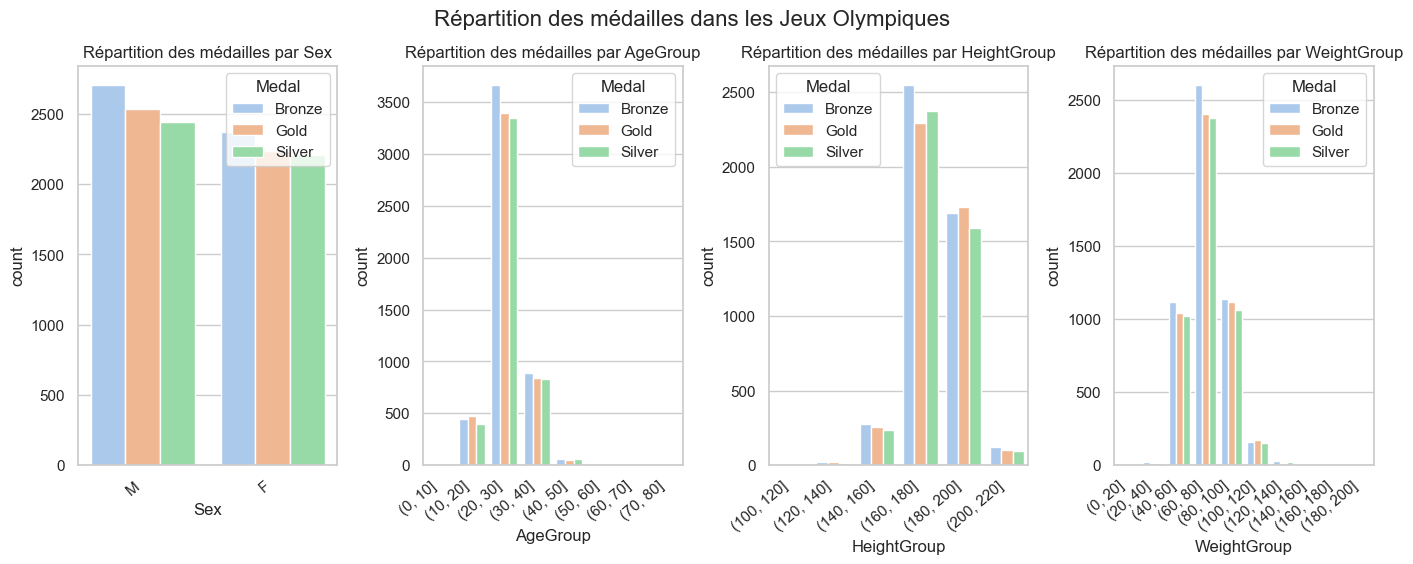

In [52] used 38.9 MiB RAM in 1.04s (system mean cpu 31%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 622.3 MiB


In [52]:
# Paramètres de style de Seaborn
sns.set(style="whitegrid")

# Créer la figure
figure = plt.figure(figsize=(14, 10))
figure.suptitle('Répartition des médailles dans les Jeux Olympiques', fontsize=16)

# Ajuster l'espacement entre les sous-graphiques
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5, wspace=0.4)

# Boucle sur les attributs pour créer les sous-graphiques
for i, col in enumerate(attrs):
    plt.subplot(2, 4, i+1)
    plt.xticks(rotation=40, ha='right')  # Rotation des étiquettes sur l'axe des x
    sns.countplot(x=col, hue='Medal', data=df_complete, palette='pastel')  # Utiliser une palette de couleurs pastel
    plt.title('Répartition des médailles par ' + col)  # Titre du sous-graphique

# Améliorer la disposition des sous-graphiques
plt.tight_layout()
plt.show()

#### Analyse visuelle

Nombre d'événements dans chaque sport au fil des années 

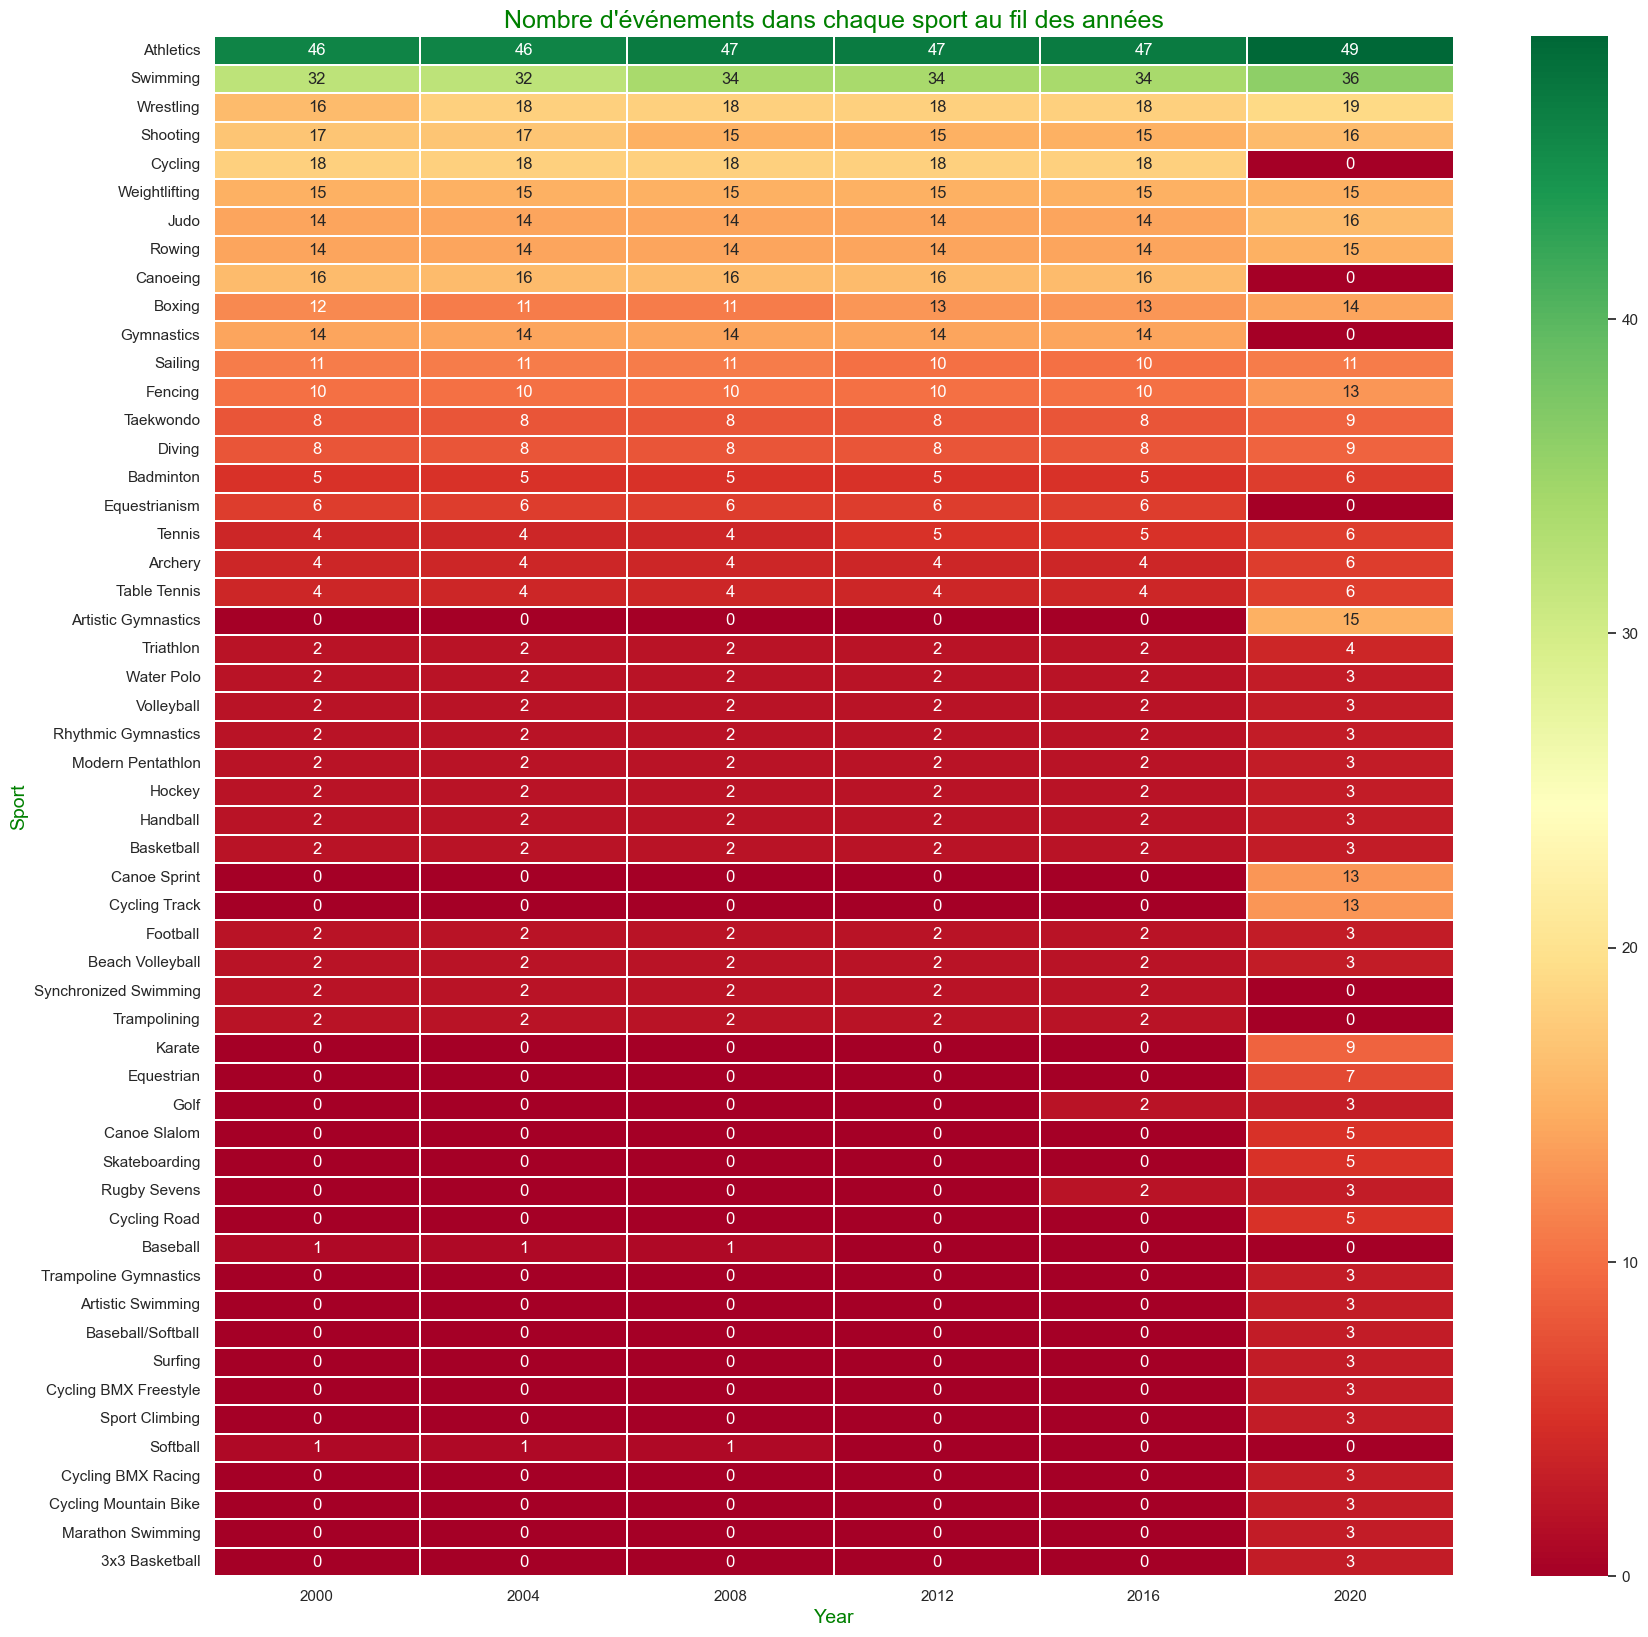

In [53] used 200.6 MiB RAM in 1.17s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 823.0 MiB


In [53]:
sport_year = df_complete.pivot_table(index='Sport', columns='Year', values='Event', aggfunc=lambda x: len(x.unique()))
sport_year.fillna(0, inplace=True)
sport_year = sport_year.reindex(sport_year.sum(axis=1).sort_values(ascending=False).index)

# Affichage de la heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(sport_year, annot=True, linewidths=0.05, cmap="RdYlGn")
plt.xlabel('Year', size=14, color="green")
plt.ylabel('Sport', size=14, color="green")
plt.title('Nombre d\'événements dans chaque sport au fil des années', size=18, color="green")
plt.show()

Nombre total de médailles remportées par pays et type de médaille

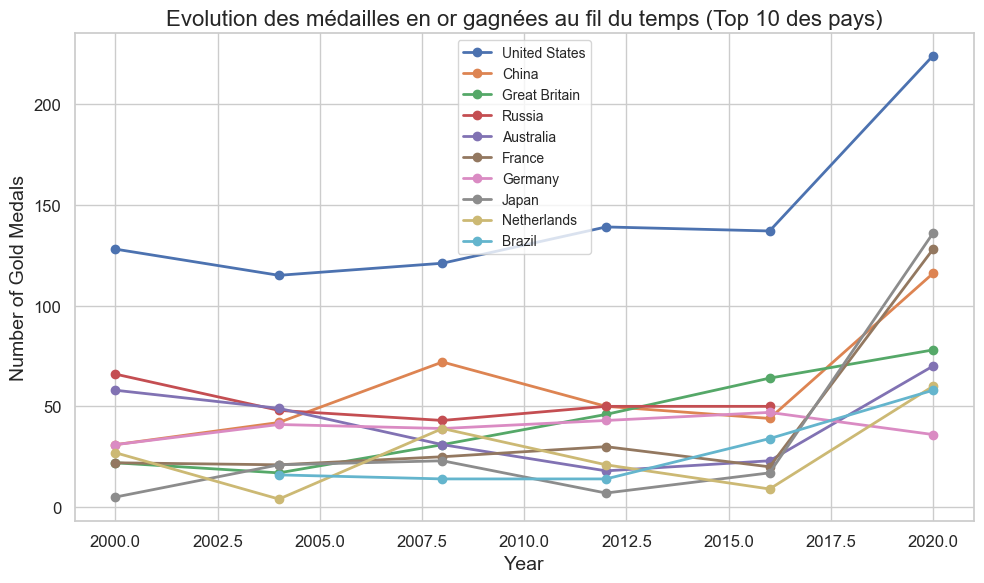

In [54] used 5.1 MiB RAM in 0.41s (system mean cpu 26%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 828.1 MiB


In [54]:
# Filter the data to include only gold medal winners
gold_medals = df_complete[df_complete['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_by_year_and_country.index, gold_medals_by_year_and_country[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution des médailles en or gagnées au fil du temps (Top 10 des pays)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y
plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


Nombre total de médailles remportées par pays et type de médaille

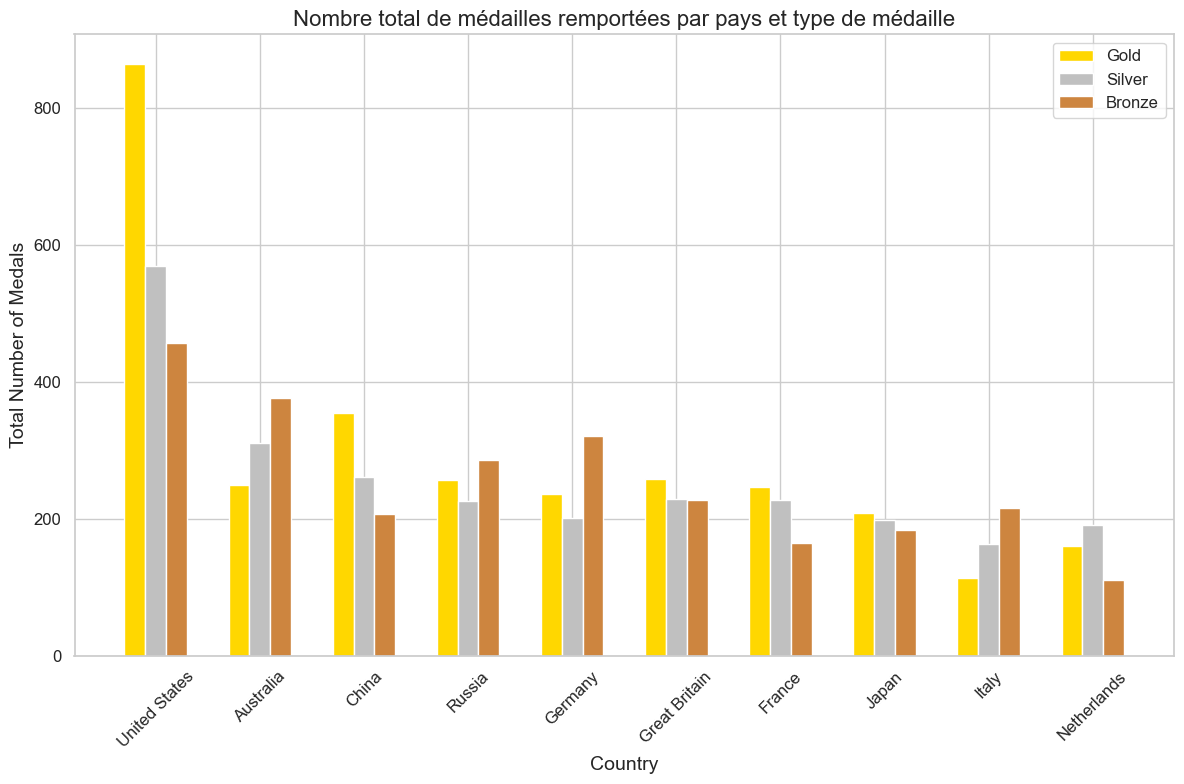

In [55] used 7.8 MiB RAM in 0.36s (system mean cpu 25%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 835.9 MiB


In [55]:
# Group the data by country and count the total number of medals won by each country and each type of medal
medals_by_country = df_complete.groupby(['Team', 'Medal']).size().unstack(fill_value=0)

# Select the top 10 countries with the most total medals
top_10_countries = medals_by_country.sum(axis=1).nlargest(10).index

# Select the medal types
medal_types = ['Gold', 'Silver', 'Bronze']

# Set the position of each bar on the x-axis
x = np.arange(len(top_10_countries))

# Set the width of the bars
width = 0.2

# Assign colors to each medal type
colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru'}

# Plotting the grouped bar graph
plt.figure(figsize=(12, 8))  # Taille de la figure

for i, medal in enumerate(medal_types):
    plt.bar(x - width + i * width, medals_by_country.loc[top_10_countries, medal], 
            width=width, label=medal, color=colors[medal])

plt.title('Nombre total de médailles remportées par pays et type de médaille', fontsize=16)  # Titre
plt.xlabel('Country', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Total Number of Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(ticks=x, labels=top_10_countries, rotation=45, fontsize=12)  # Étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y
plt.legend(fontsize=12)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


Ratio de l'évolution des médailles d'or par athlète au fil du temps (Top 10 des pays)
(proportionnelement, quel pays obtient le pus de médailles)

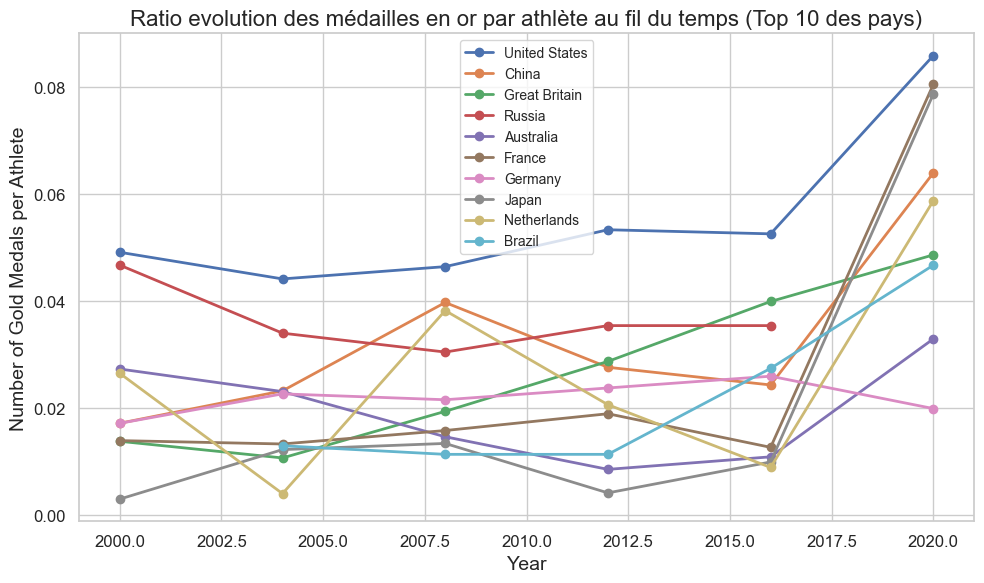

In [56] used 1.7 MiB RAM in 0.43s (system mean cpu 26%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 837.6 MiB


In [56]:
# Calculate the total number of athletes per country
total_athletes_per_country = df_complete.groupby('Team')['Name'].nunique()

# Filter the data to include only gold medal winners
gold_medals = df_complete[df_complete['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Calculate the number of gold medals per athlete for each country and each year
gold_medals_per_athlete = gold_medals_by_year_and_country.div(total_athletes_per_country, axis=1)

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals per athlete over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_per_athlete.index, gold_medals_per_athlete[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Ratio evolution des médailles en or par athlète au fil du temps (Top 10 des pays)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals per Athlete', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()

Plus forte évolution des médailles remportées par équipe

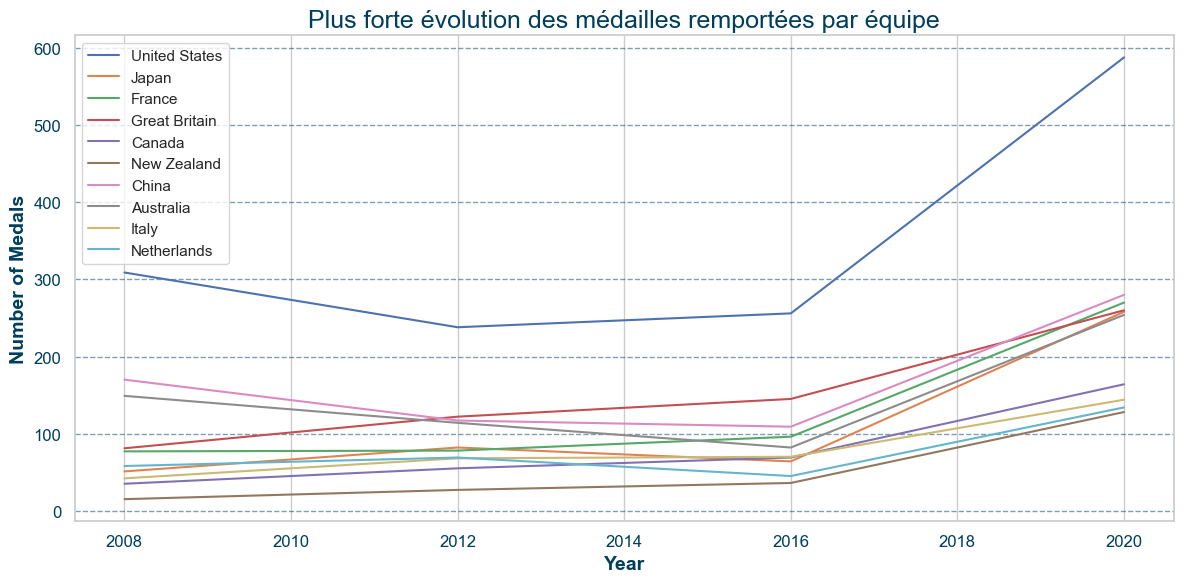

In [57] used 16.7 MiB RAM in 0.43s (system mean cpu 31%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 854.3 MiB


In [57]:
# Filter the data to include only Summer Olympic Games between 2010 and 2020
summer_games = df_complete[(df_complete['Season'] == 'Summer') & (df_complete['Year'] >= 2008) & (df_complete['Year'] <= 2020)]

# Group the data by team and year, and calculate the total number of medals won by each team in each year
medals_by_year = summer_games.groupby(['Team', 'Year'])['Medal'].count().unstack()

# Calculate the difference in the number of medals won by each team between the first year and the last year
medal_difference = medals_by_year.iloc[:, -1] - medals_by_year.iloc[:, 0]

# Sort the teams based on the difference in the number of medals won in descending order
sorted_teams = medal_difference.sort_values(ascending=False)

# Select the top 5 teams with the largest increase in medals won
top_5_teams = sorted_teams.index[:10]

# Create a line chart showing the number of medals won by the top 5 teams in each year
plt.figure(figsize=(12, 6))
for team in top_5_teams:
    plt.plot(medals_by_year.loc[team], label=team)
plt.title('Plus forte évolution des médailles remportées par équipe', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Retrait des variables devenues ici inutiles
df_complete.drop(columns=['AgeGroup', 'WeightGroup', 'HeightGroup'], inplace=True)

In [58] used 3.6 MiB RAM in 0.12s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 857.8 MiB


## Traitement des valeurs aberrantes

In [59]:
# A faire
# TODO : Guillaume

In [59] used -0.0 MiB RAM in 0.10s (system mean cpu 16%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 857.8 MiB


<Axes: >

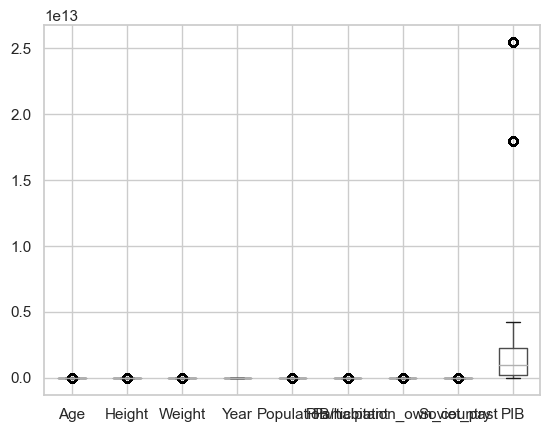

In [60] used 25.9 MiB RAM in 0.72s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 883.6 MiB


In [60]:
df_complete.boxplot()

In [61]:
# On va modifier les plus hauts outliers identifiés pour Age, Height et Weight par la valeur du 99ème quantile

cols = ['Age', 'Height', 'Weight']
low = .05
high = .99 # Retourne les valeurs au 99ème quantile

# Calcul des quantiles
quant_df =  df_complete[cols].quantile([low, high])
print(quant_df)

# Remplacement des outliers par le 99ème quantile
for col in cols:
    high_val = quant_df[col].loc[high]
    df_complete[col] = np.where(df_complete[col] > high_val, high_val, df_complete[col])


       Age  Height  Weight
0.05  18.0    2.08    51.0
0.99  44.0  202.00   117.0
In [61] used 7.1 MiB RAM in 0.12s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 890.8 MiB


In [62]:
higher = quant_df.loc[high,'Age']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df_complete['Age'] = df_complete['Age'].apply(func)

In [62] used 1.3 MiB RAM in 0.12s (system mean cpu 12%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 892.1 MiB


In [63]:
higher = quant_df.loc[high,'Height']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df_complete['Height'] = df_complete['Height'].apply(func)

In [63] used 0.0 MiB RAM in 0.12s (system mean cpu 13%, single max cpu 75%), peaked 0.0 MiB above final usage, current RAM usage now 892.1 MiB


In [64]:
higher = quant_df.loc[high,'Weight']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df_complete['Weight'] = df_complete['Weight'].apply(func)

In [64] used 0.1 MiB RAM in 0.12s (system mean cpu 49%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 892.2 MiB


In [65]:
# On vérifie que pour les valeurs les plus hautes, on a bien modifié la valeur

df_complete[df_complete['Age'].ge(quant_df.loc[high,'Age'])]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,...,Sport,Event,Medal,Population,PIB/habitant,Country,Host_country,Participation_own_country,Soviet_past,PIB
71,"William ""Bill"" Abbott Jr.",M,44.0,172.0,80.0,Canada,CAN,2000 Summer,2000,Summer,...,Sailing,Sailing Mixed Three Person Keelboat,NaN,35851774.0,43248.529909,Canada,Australia,0,0,2.139840e+12
846,Teruyoshi Akiyama,M,44.0,168.0,65.0,Japan,JPN,2016 Summer,2016,Summer,...,Shooting,"Shooting Men's Rapid-Fire Pistol, 25 metres",NaN,126958472.0,32477.215145,Japan,Brazil,0,0,4.231140e+12
907,Nasser Salih Nasser Abdullah Al-Attiya,M,44.0,178.0,82.0,Qatar,QAT,2016 Summer,2016,Summer,...,Shooting,Shooting Men's Skeet,NaN,2235355.0,73653.394435,Qatar,Brazil,0,0,2.372960e+11
931,Dadallah Noor Mohamed Al-Bulushi,M,44.0,172.0,86.0,Oman,OMA,2008 Summer,2008,Summer,...,Shooting,"Shooting Men's Small-Bore Rifle, Prone, 50 metres",NaN,4490541.0,15550.676251,Oman,China,0,0,1.146670e+11
940,Fehaid Al-Deehani,M,44.0,178.0,95.0,Kuwait,KUW,2012 Summer,2012,Summer,...,Shooting,Shooting Men's Trap,Bronze,3892115.0,29300.575575,Kuwait,United Kingdom,0,0,1.845580e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86112,Jasna ekari (Brajkovi-),F,44.0,175.0,70.0,Serbia,SRB,2012 Summer,2012,Summer,...,Shooting,"Shooting Women's Sporting Pistol, 25 metres",NaN,7221365.0,8794.000000,Serbia,United Kingdom,0,0,6.350175e+10
86702,CHOW Felice Aisha,F,44.0,168.0,57.6,Trinidad and Tobago,TTO,Tokyo 2020,2020,Summer,...,Rowing,NaN,NaN,1531044.0,18222.000000,Trinidad,Japan,0,0,2.789908e+10
87113,CHOW Felice Aisha,F,44.0,168.0,57.6,Trinidad and Tobago,TTO,Tokyo 2020,2020,Summer,...,Rowing,NaN,NaN,1531044.0,18222.000000,Trinidad,Japan,0,0,2.789908e+10
89128,Park Yong-Hui,F,44.0,160.0,63.0,North Korea,PRK,2016 Summer,2016,Summer,...,Shooting,Shooting Women's Trap,NaN,51815810.0,32138.000000,South Korea,Brazil,0,0,1.665250e+12


In [65] used 4.4 MiB RAM in 0.12s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 896.5 MiB


df_complete[df_complete['Height'].ge(quant_df.loc[Height'])]

In [66]:
df_complete[df_complete['Weight'].ge(quant_df.loc[high,'Weight'])]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,...,Sport,Event,Medal,Population,PIB/habitant,Country,Host_country,Participation_own_country,Soviet_past,PIB
3,Timo Antero Aaltonen,M,31.0,189.0,117.0,Finland,FIN,2000 Summer,2000,Summer,...,Athletics,Athletics Men's Shot Put,NaN,5482013.0,42311.036231,Finland,Australia,0,0,2.808260e+11
105,Yasser Abdel Rahman Sakr,M,30.0,180.0,117.0,Egypt,EGY,2008 Summer,2008,Summer,...,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",NaN,91508084.0,3614.746766,Egypt,China,0,0,4.767480e+11
181,Muminzhon Abdullayev,M,22.0,190.0,117.0,Uzbekistan,UZB,2012 Summer,2012,Summer,...,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",NaN,31299500.0,2132.070368,Uzbekistan,United Kingdom,0,1,8.039185e+10
182,Muminzhon Abdullayev,M,26.0,190.0,117.0,Uzbekistan,UZB,2016 Summer,2016,Summer,...,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",NaN,31299500.0,2132.070368,Uzbekistan,Brazil,0,1,8.039185e+10
202,Mukhamadmurod Abdurakhmonov,M,29.0,192.0,117.0,Tajikistan,TJK,2016 Summer,2016,Summer,...,Judo,Judo Men's Heavyweight,NaN,8481855.0,925.911888,Tajikistan,Brazil,0,1,1.049212e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85464,Lee Hsiao-Hung,F,21.0,183.0,117.0,Chinese Taipei,TPE,2000 Summer,2000,Summer,...,Judo,Judo Women's Heavyweight,NaN,23923276.0,44460.000000,Taiwan,Australia,0,0,7.626700e+11
85465,Lee Hsiao-Hung,F,25.0,183.0,117.0,Chinese Taipei,TPE,2004 Summer,2004,Summer,...,Judo,Judo Women's Heavyweight,NaN,23923276.0,44460.000000,Taiwan,Greece,0,0,7.626700e+11
85496,Li Wen-Hua (-Tsai-Yi),F,22.0,180.0,117.0,Chinese Taipei,TPE,2012 Summer,2012,Summer,...,Athletics,Athletics Women's Discus Throw,NaN,23923276.0,44460.000000,Taiwan,United Kingdom,0,0,7.626700e+11
87671,Giovanna Jos Blanco Bazon,F,21.0,175.0,117.0,Venezuela,VEN,2004 Summer,2004,Summer,...,Judo,Judo Women's Heavyweight,NaN,29254044.0,2624.000000,Venezuela,Greece,0,0,9.200000e+10


In [66] used 0.1 MiB RAM in 0.12s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 896.6 MiB


## Création d'un nouveau dataframe aggrégeant toutes les données

In [67]:
# Normalisation des pays. Certains sont écrits avec des suffixes (Ex: Brazil-1, Brazil-2)
replacement_dict = {}

old_countries_to_process = df_complete.Team.unique()

for i in old_countries_to_process:
    replacement_dict[i] = re.sub(r'[\d-]', '', i)

df_complete = df_complete.replace({"Team": replacement_dict})
df_complete.drop_duplicates(subset=['Event', 'Team', 'Year', 'Medal'], inplace=True)
participation_own_country_soviet = df_complete[['Year','Team', 'Participation_own_country', 'Soviet_past']].drop_duplicates()

df_complete['Medal'] = df_complete['Medal'].replace(np.nan, 0)
df_complete['Medal'] = df_complete['Medal'].apply(lambda x: 0 if x==0 else 1)

medals_per_year = df_complete.groupby(['Team', 'Year']).agg({'Medal': 'sum'}).reset_index()
concat = medals_per_year.merge(participation_own_country_soviet, how='inner', on=['Team', 'Year'])
concat[concat['Team'] == "France"]

,Team,Year,Medal,Participation_own_country,Soviet_past
410,France,2000,38,0,0
411,France,2004,33,0,0
412,France,2008,41,0,0
413,France,2012,35,0,0
414,France,2016,42,0,0
415,France,2020,32,0,0


In [67] used 18.9 MiB RAM in 0.95s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 915.5 MiB


## Encodage des données

Encodage des médailles

In [68]:
df_complete = pd.read_csv('data/testetstest.csv')

In [68] used 10.3 MiB RAM in 0.28s (system mean cpu 28%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 925.7 MiB


In [69]:
# Encodage du sexe
df_complete['Sex'].replace(['F','M'],['0', '1'],inplace=True)

# transform the medal into numeric values
df_complete['Medal'] = df_complete.Medal.fillna('0')

#JO Hivers = 0; été = 1
df_complete['Season'].replace(['Winter','Summer'],['0', '1'],inplace=True)
df_complete = df_complete.drop(df_complete[df_complete['Season'] == '0'].index)

# On retire les valeurs nulles de Soviet_past
df_complete['Soviet_past'].fillna(0, inplace=True)

In [69] used 9.5 MiB RAM in 0.16s (system mean cpu 23%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 935.2 MiB


In [70]:
# Encodage du sport 
encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoder.fit(df_complete[['Sport']])
columns_name = encoder.get_feature_names_out(['Sport'])
df_encoded = pd.DataFrame(encoder.transform(df_complete[['Sport']]))
df_encoded.columns = columns_name

# Reset index of df_encoded
df_encoded.reset_index(drop=True, inplace=True)

# # Concatenate df_complete and df_encoded
df_complete = pd.concat([df_complete, df_encoded], axis=1)

df_complete = df_complete.drop('Season', axis=1)

In [70] used 37.8 MiB RAM in 0.17s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 973.1 MiB


/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_16472/23773345.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_complete.corr()


<Axes: >

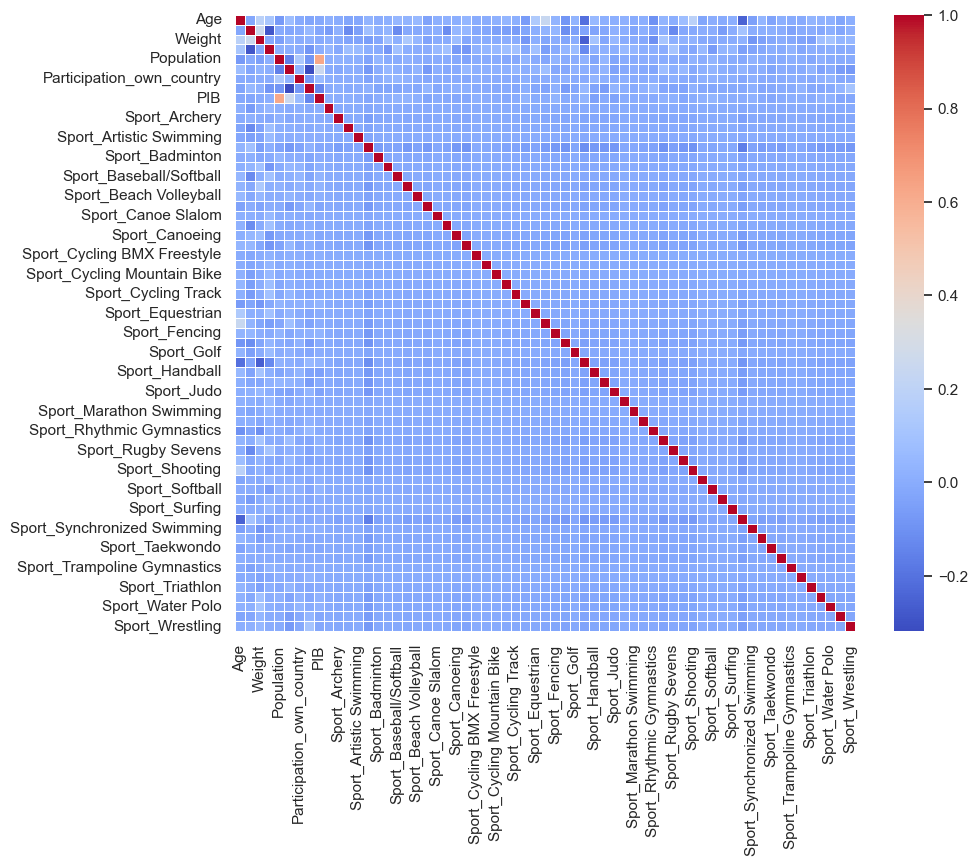

In [71] used 43.3 MiB RAM in 1.33s (system mean cpu 19%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1016.4 MiB


In [71]:
# Corrélogramme 
correlation_matrix = df_complete.corr()
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', linewidths=0.5)

On n'observe pas de forte corrélation entre les différents attributs (NOE à compléter)

In [72]:
# Encodage de l'âge
df_complete['Age'] = pd.cut(df_complete.Age, range(0, 80, 5), right=False)

# Encodage du poids
df_complete['Weight'] = pd.cut(df_complete.Weight, range(0, 230, 10), right=False)

# Encodage de la taille
df_complete['Height'] = pd.cut(df_complete.Height, range(0, 250, 10), right=False)

In [72] used 0.0 MiB RAM in 0.12s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1016.4 MiB


In [73]:
# PIB Groups
# Calculer les quantiles
quantiles = [0.20, 0.40, 0.60, 0.80]

# Créer les intervalles pour les groupes en utilisant les quantiles
bins = df_complete['PIB'].quantile(quantiles)

# Ajouter les bornes extrêmes
bins = [float('-inf')] + list(bins) + [float('inf')]

# Assigner les groupes en utilisant pd.cut() avec les intervalles définis
df_complete['PIB_groups'] = pd.cut(df_complete['PIB'], bins=bins, labels=[1, 2, 3, 4, 5], right=False)

# Retrait des variables inutiles
df_complete.drop(columns=['PIB'], inplace=True)
df_complete

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,City,...,Sport_Taekwondo,Sport_Tennis,Sport_Trampoline Gymnastics,Sport_Trampolining,Sport_Triathlon,Sport_Volleyball,Sport_Water Polo,Sport_Weightlifting,Sport_Wrestling,PIB_groups
0,A Lamusi,1,"[20, 25)","[170, 180)","[60, 70)",China,CHN,2012 Summer,2012,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,Jyri Tapani Aalto,1,"[30, 35)","[170, 180)","[70, 80)",Finland,FIN,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Timo Antero Aaltonen,1,"[30, 35)","[180, 190)","[110, 120)",Finland,FIN,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Fritz Aanes,1,"[20, 25)","[180, 190)","[80, 90)",Norway,NOR,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,Fritz Aanes,1,"[25, 30)","[180, 190)","[80, 90)",Norway,NOR,2004 Summer,2004,Athina,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90103,VERDINO Claudia,0,"[20, 25)","[160, 170)","[50, 60)",Monaco,MON,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
90104,VIDIAUX Marcia,0,"[20, 25)","[140, 150)","[50, 60)",Cuba,CUB,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
90105,WRAY Shalysa,0,"[20, 25)","[180, 190)","[50, 60)",Cayman Islands,CAY,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
90106,YANG Xiaoxin,0,"[30, 35)","[160, 170)","[50, 60)",Monaco,MON,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [73] used 47.3 MiB RAM in 0.18s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1063.7 MiB


In [74]:
categorical_vars = df_complete.select_dtypes(include=['object', 'category'])

p_values = {}
for var1, var2 in combinations(categorical_vars.columns, 2):
    contingency_table = pd.crosstab(categorical_vars[var1], categorical_vars[var2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values[(var1, var2)] = p


dependent_vars = {var_pair: p_value for var_pair, p_value in p_values.items() if p_value < 0.05}
dependent_vars

{('Name', 'Sex'): 0.0,
 ('Name', 'Age'): 0.0,
 ('Name', 'Height'): 0.0,
 ('Name', 'Weight'): 0.0,
 ('Name', 'Team'): 0.0,
 ('Name', 'NOC'): 0.0,
 ('Name', 'Games'): 0.0,
 ('Name', 'City'): 0.0,
 ('Name', 'Sport'): 0.0,
 ('Name', 'Event'): 0.0,
 ('Name', 'Medal'): 0.0,
 ('Name', 'Country'): 0.0,
 ('Name', 'Host_country'): 0.0,
 ('Name', 'PIB_groups'): 0.0,
 ('Sex', 'Age'): 0.0,
 ('Sex', 'Height'): 0.0,
 ('Sex', 'Weight'): 0.0,
 ('Sex', 'Team'): 0.0,
 ('Sex', 'NOC'): 0.0,
 ('Sex', 'Games'): 3.738017071932109e-68,
 ('Sex', 'City'): 3.738017071932109e-68,
 ('Sex', 'Sport'): 0.0,
 ('Sex', 'Event'): 0.0,
 ('Sex', 'Medal'): 1.8957923478638722e-13,
 ('Sex', 'Country'): 0.0,
 ('Sex', 'Host_country'): 3.738017071932321e-68,
 ('Sex', 'PIB_groups'): 2.050397628721237e-114,
 ('Age', 'Height'): 0.0,
 ('Age', 'Weight'): 0.0,
 ('Age', 'Team'): 0.0,
 ('Age', 'NOC'): 0.0,
 ('Age', 'Games'): 0.0,
 ('Age', 'City'): 0.0,
 ('Age', 'Sport'): 0.0,
 ('Age', 'Event'): 0.0,
 ('Age', 'Medal'): 3.0230447900810085e

In [74] used 593.6 MiB RAM in 20.45s (system mean cpu 13%, single max cpu 100%), peaked 720.9 MiB above final usage, current RAM usage now 1657.4 MiB


### Nettoyage des colonnes inutiles pour l'analyse

In [75]:
# Drop les colonnes qui ne servent à R
# df_complete.drop(columns=['Team', 'Name', 'Games', 'City', 'Event', 'Sport', 'Host_country', 'Country'], inplace=True)

In [75] used 0.0 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1657.4 MiB


In [76]:
df_complete

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,City,...,Sport_Taekwondo,Sport_Tennis,Sport_Trampoline Gymnastics,Sport_Trampolining,Sport_Triathlon,Sport_Volleyball,Sport_Water Polo,Sport_Weightlifting,Sport_Wrestling,PIB_groups
0,A Lamusi,1,"[20, 25)","[170, 180)","[60, 70)",China,CHN,2012 Summer,2012,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,Jyri Tapani Aalto,1,"[30, 35)","[170, 180)","[70, 80)",Finland,FIN,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Timo Antero Aaltonen,1,"[30, 35)","[180, 190)","[110, 120)",Finland,FIN,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Fritz Aanes,1,"[20, 25)","[180, 190)","[80, 90)",Norway,NOR,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,Fritz Aanes,1,"[25, 30)","[180, 190)","[80, 90)",Norway,NOR,2004 Summer,2004,Athina,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90103,VERDINO Claudia,0,"[20, 25)","[160, 170)","[50, 60)",Monaco,MON,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
90104,VIDIAUX Marcia,0,"[20, 25)","[140, 150)","[50, 60)",Cuba,CUB,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
90105,WRAY Shalysa,0,"[20, 25)","[180, 190)","[50, 60)",Cayman Islands,CAY,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
90106,YANG Xiaoxin,0,"[30, 35)","[160, 170)","[50, 60)",Monaco,MON,Tokyo 2020,2020,Tokyo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [76] used 1.2 MiB RAM in 0.14s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1658.6 MiB


In [77]:
# Export du dataframe
df_complete.to_csv('data/df_complete.csv', index=False)

In [77] used 2.1 MiB RAM in 2.78s (system mean cpu 12%, single max cpu 100%), peaked 17.9 MiB above final usage, current RAM usage now 1660.7 MiB


In [78]:
df_complete.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,City,...,Sport_Taekwondo,Sport_Tennis,Sport_Trampoline Gymnastics,Sport_Trampolining,Sport_Triathlon,Sport_Volleyball,Sport_Water Polo,Sport_Weightlifting,Sport_Wrestling,PIB_groups
0,A Lamusi,1,"[20, 25)","[170, 180)","[60, 70)",China,CHN,2012 Summer,2012,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,Jyri Tapani Aalto,1,"[30, 35)","[170, 180)","[70, 80)",Finland,FIN,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Timo Antero Aaltonen,1,"[30, 35)","[180, 190)","[110, 120)",Finland,FIN,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Fritz Aanes,1,"[20, 25)","[180, 190)","[80, 90)",Norway,NOR,2000 Summer,2000,Sydney,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,Fritz Aanes,1,"[25, 30)","[180, 190)","[80, 90)",Norway,NOR,2004 Summer,2004,Athina,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [78] used 0.0 MiB RAM in 0.12s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1660.7 MiB


## Traitement des valeurs manquantes 

Effectivement notre base de données possède de nombreuses valeurs manquantes 

In [79]:
# df.isna().sum()

In [79] used 0.0 MiB RAM in 0.11s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1660.8 MiB


In [80]:
### Première solution : Web Scrapping (code Nathan + FLO)

In [80] used -0.3 MiB RAM in 0.10s (system mean cpu 85%, single max cpu 100%), peaked 0.3 MiB above final usage, current RAM usage now 1660.5 MiB


## Tests de corrélations/lois stats (Shapiro-Wilk, Spearman, Pearson)

In [81]:
# TODO: Noé

In [81] used -25.1 MiB RAM in 0.10s (system mean cpu 41%, single max cpu 100%), peaked 25.1 MiB above final usage, current RAM usage now 1635.4 MiB


## Aggrégation des données par Team/Année/Event pour pouvoir calculer les médailles

In [82]:
# TODO: Nathan: Essayer d'appliquer le code
# Voir plus haut

In [82] used 0.0 MiB RAM in 0.11s (system mean cpu 40%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1635.4 MiB
